# Feature importance check

In [1]:

from src.util import read_results, train_test_validate_split, ExplodeColumns, model_operators, eval_result
import numpy as np 
import pandas as pd
import xgboost
import matplotlib.pyplot as plt
# plt.style.use("/home/pepijn/Documents/uni/y5/thesis/writing/msc-thesis-figures/std-colors.mplstyle")

%load_ext autoreload
%autoreload 2

In [2]:
result_df = read_results(from_parquet=True)

In [3]:
list_features = [x for x in result_df.columns if result_df[x].apply(lambda x: isinstance(x, (list, np.ndarray))).any()]
result_df = ExplodeColumns(columns=list_features, max_len=5).transform(result_df)

Expanding columns: 100%|██████████| 7/7 [03:25<00:00, 29.42s/it]


In [4]:
categorical_columns = result_df.select_dtypes(include=['object']).columns.tolist()
print(f"Dropping {categorical_columns}")
for col in categorical_columns:
    result_df[col] = result_df[col].astype('category')

Dropping ['dataset', 'operator', 'join', 'compute_unit', 'source_file', 'dataset_type', 'compute_type', 'parallelism', 'gpu__architecture']


In [5]:
target_cols = ['speedup', 'times_mean', 'label', 'time_saved', 'materialized_times_mean']

def split_data(df, target_cols):
    X = df.drop(columns=target_cols)
    y = df[target_cols]
    return X, y

train, test, validate = train_test_validate_split(result_df)
X_train, y_train = split_data(train, target_cols)
X_test, y_test = split_data(test, target_cols)
X_validate, y_validate = split_data(validate, target_cols)


train set:
	Records: 210953
	Positive (speedup > 1 with factorizing)/Negative: 39406/171547 = 0.23 s
	Dataset types: ['synthetic', 'hamlet']
Categories (3, object): ['hamlet', 'synthetic', 'tpc_ai']
\Compute Units: ['CPU 32c', '1080', 'CPU 16c', 'CPU 08c', 'v100', '2080', 'a40', 'p100']
Categories (8, object): ['1080', '2080', 'CPU 08c', 'CPU 16c', 'CPU 32c', 'a40', 'p100', 'v100']
test set:
	Records: 90409
	Positive (speedup > 1 with factorizing)/Negative: 17014/73395 = 0.23 s
	Dataset types: ['synthetic', 'hamlet']
Categories (3, object): ['hamlet', 'synthetic', 'tpc_ai']
\Compute Units: ['2080', '1080', 'CPU 16c', 'a40', 'v100', 'CPU 08c', 'CPU 32c', 'p100']
Categories (8, object): ['1080', '2080', 'CPU 08c', 'CPU 16c', 'CPU 32c', 'a40', 'p100', 'v100']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic', 'hamlet', 'tpc_ai']
Categories (3, object): ['hamlet', 'synthetic', 'tpc_ai']
\Compute Units: ['p100',

In [6]:
cols = result_df.head(1).T

In [7]:
from sklearn.metrics import mean_squared_error
import seaborn as sns


def plot_boundary(y_true, y_pred, lower=-1.0, upper=1.0, step=0.1, target_col=None, full_dataset=None, ax=None):
    # Create a list to store the results
    results = []

    # Loop over the range of boundaries
    x = np.arange(lower, upper, step)
    for boundary in x:
        result = eval_result(y_true, y_pred=y_pred > boundary, full_dataset=full_dataset, target_col=target_col)
        results.append({"boundary": boundary, **result[2]})

    dd = pd.DataFrame(results)
    ax = sns.scatterplot(data=dd, x="boundary", y="y_pred_time_saved", label="time_saved", ax=ax)
    sns.scatterplot(data=dd, x="boundary", y="y_pred_speedup_real", ax=ax.twinx(), label="speedup", color="orange")
    ax.grid()
    ax.legend(loc="lower right")
    ax.set_title(f"Boundary vs. Time saved {target_col}")
    return ax


def train_and_eval(name, X_train, y_train, X_test, y_test, X_validate, y_validate, target_col, only_model=False, estimator_kwargs={}):
    model_operators_mask_test = X_test["operator"].isin(model_operators)
    X_test = X_test.loc[model_operators_mask_test]
    y_test = y_test.loc[model_operators_mask_test]

    model_operators_mask_validate = X_validate["operator"].isin(model_operators)
    X_validate = X_validate[model_operators_mask_validate]
    y_validate = y_validate.loc[model_operators_mask_validate]
    df_filtered = result_df[result_df["operator"].isin(model_operators)]
    if only_model:
        # Filter the datasets based on the condition
        model_operators_mask_train = X_train["operator"].isin(model_operators)
        X_train = X_train[model_operators_mask_train]
        y_train = y_train.loc[model_operators_mask_train]
    else:
        df_filtered = result_df

    clf = xgboost.XGBRegressor(enable_categorical=True, **estimator_kwargs)
    clf.fit(X_train, y_train[target_col])
    display(pd.DataFrame(zip(X_train.columns, clf.feature_importances_)).sort_values(1, ascending=False).head(10))
    X_validate = X_validate[X_validate.operator.isin(model_operators)]
    y_validate= y_validate.loc[X_validate.index]
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    for X, y, dataset_name, ax in zip(
        [X_train, X_test, X_validate], [y_train, y_test, y_validate], ["train", "test", "validate"], axs
    ):
        plt.sca(ax)
        y_true = y[target_col]
        y_pred = clf.predict(X)
        print(name, dataset_name, mean_squared_error(y_true, y_pred))

        if isinstance(target_col, list):
            print("Assuming target cols are materialized_times_mean and times_mean")
            pred = pd.DataFrame(y_pred, index=y_true.index)
            pred.columns = y_true.columns
            y_pred = pred["materialized_times_mean"] - pred["times_mean"]
            y_true = y_true["materialized_times_mean"] - y_true["times_mean"]
            eval_target_col = 'time_saved'
        else:
            eval_target_col = target_col

        lower, upper = (0.8, 2.0) if target_col == "speedup" else (-1.0, 1.0)
        ax = plot_boundary(y_true, y_pred, lower,upper, target_col=eval_target_col, full_dataset=df_filtered.loc[y_true.index],ax=ax)
        xgb_results[(name, dataset_name)] = eval_result(
            y_true,
            y_pred,
            full_dataset=df_filtered.loc[y_true.index],
            model_name=f"{name}: {dataset_name}",
            target_col=eval_target_col,
            plot=True,
        )[0]
    return clf

[(['times_mean', 'materialized_times_mean'], True),
 (['times_mean', 'materialized_times_mean'], False),
 ('speedup', True),
 ('speedup', False),
 ('time_saved', False),
 ('time_saved', True)]

,0,1
0,operator,0.299314
11,mem_fac_read,0.199484
1,num_cores,0.108924
9,mem_mat_read,0.047826
21,comp_scalar_dense,0.041242
3,cardinality_T,0.040232
24,comp_matrix_dense,0.034483
14,comp_lmm_mat,0.029161
31,mem_read_colsum,0.026388
17,comp_lmm_fac,0.020667


XGB.1 train 0.0752654189837509
Assuming target cols are materialized_times_mean and times_mean
XGB.1 test 0.21901250223494184
Assuming target cols are materialized_times_mean and times_mean
XGB.1 validate 18.479753783900335
Assuming target cols are materialized_times_mean and times_mean


,0,1
0,operator,0.271152
11,mem_fac_read,0.129023
1,num_cores,0.105764
21,comp_scalar_dense,0.098119
9,mem_mat_read,0.063358
10,mem_mat_write,0.053982
3,cardinality_T,0.032069
24,comp_matrix_dense,0.030973
68,features_2,0.028931
14,comp_lmm_mat,0.022752


XGB.2 train 0.020572416375778516
Assuming target cols are materialized_times_mean and times_mean
XGB.2 test 0.22855478265924256
Assuming target cols are materialized_times_mean and times_mean
XGB.2 validate 18.42592045788374
Assuming target cols are materialized_times_mean and times_mean


,0,1
37,comp_mat,0.150491
29,mem_read_rowsum,0.071264
39,comp_ratio,0.062741
27,mem_read_matrix_dense,0.060285
44,nnz_T,0.057601
1,num_cores,0.056287
47,c_T,0.046820
0,operator,0.040775
10,mem_mat_write,0.036727
45,nnz_S_sum,0.036683


XGB.3 train 0.005919180525815778
XGB.3 test 0.02403432110289183
XGB.3 validate 2.538483943284265


,0,1
2,selectivity,0.345654
55,gpu_cache_size_l1,0.190672
47,c_T,0.167203
73,r_S_2,0.060661
0,operator,0.047890
69,features_3,0.035794
52,gpu__architecture,0.035750
1,num_cores,0.032546
43,FR,0.025873
44,nnz_T,0.012681


XGB.4 train 3.595564669147174
XGB.4 test 0.05162110282504582
XGB.4 validate 9.501299183355675


,0,1
0,operator,0.333111
1,num_cores,0.116723
72,r_S_1,0.091791
45,nnz_S_sum,0.084666
11,mem_fac_read,0.056736
6,complexity_ratio,0.050094
70,features_4,0.034322
5,join,0.028862
3,cardinality_T,0.028199
39,comp_ratio,0.020320


XGB.5 train 0.042215145256277384
XGB.5 test 0.4645461196413927
XGB.5 validate 10.680846754550238


,0,1
0,operator,0.309660
1,num_cores,0.131797
72,r_S_1,0.088099
45,nnz_S_sum,0.080432
11,mem_fac_read,0.068471
6,complexity_ratio,0.049658
39,comp_ratio,0.032492
5,join,0.030719
3,cardinality_T,0.028460
37,comp_mat,0.022026


/tmp/ipykernel_152064/3053750103.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 3, figsize=(15, 4))


XGB.6 train 0.151779174751229
XGB.6 test 0.4328920278500985
XGB.6 validate 9.509992128187646


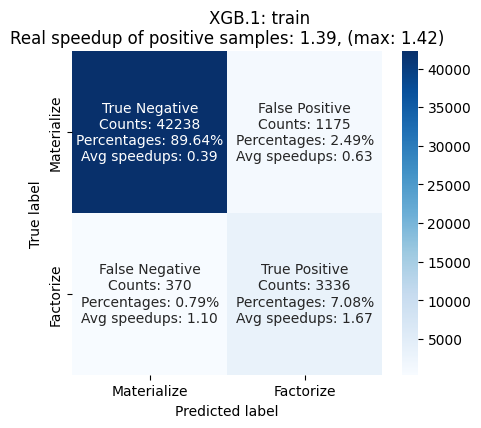

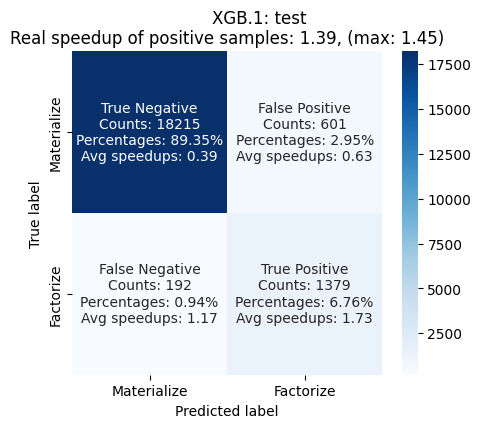

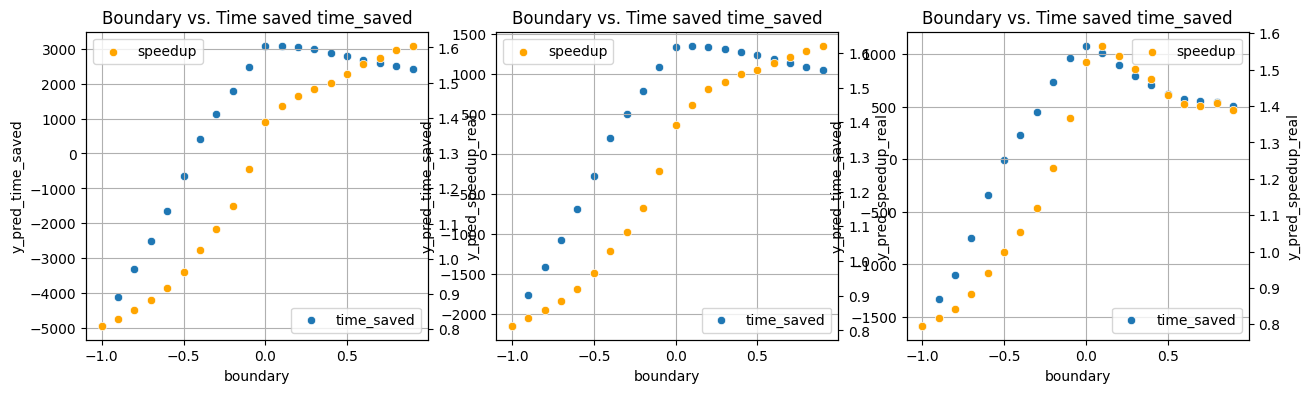

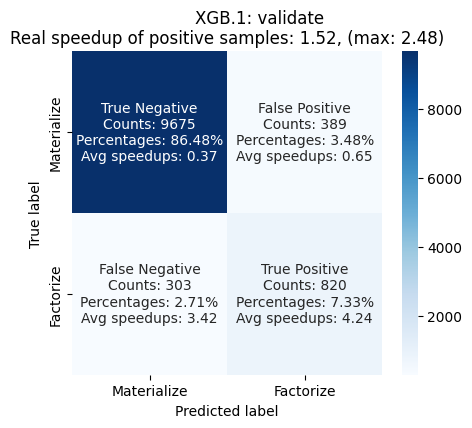

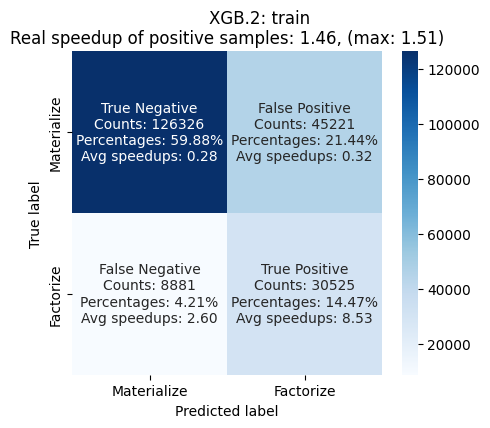

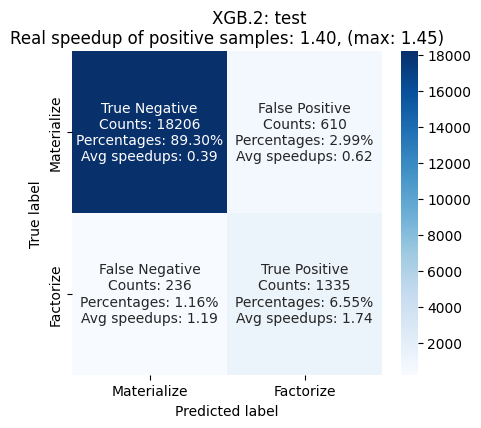

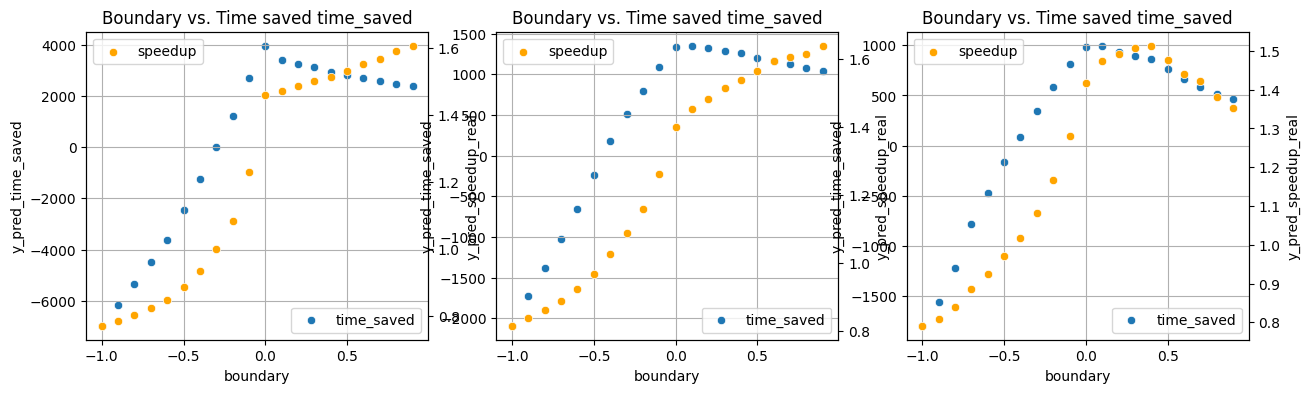

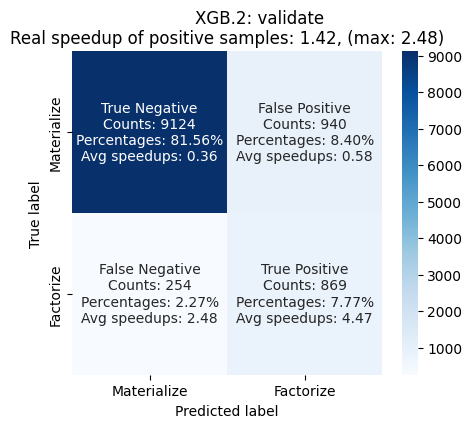

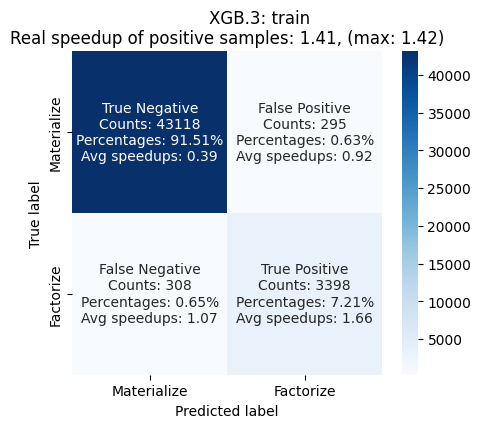

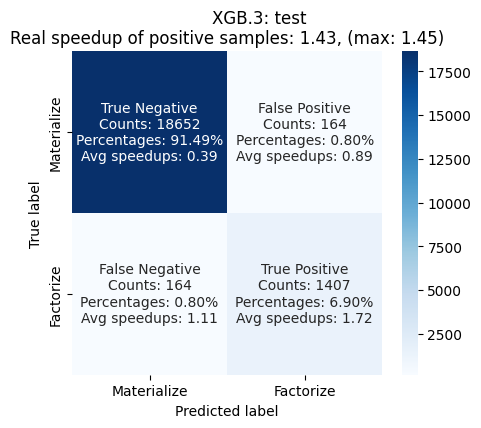

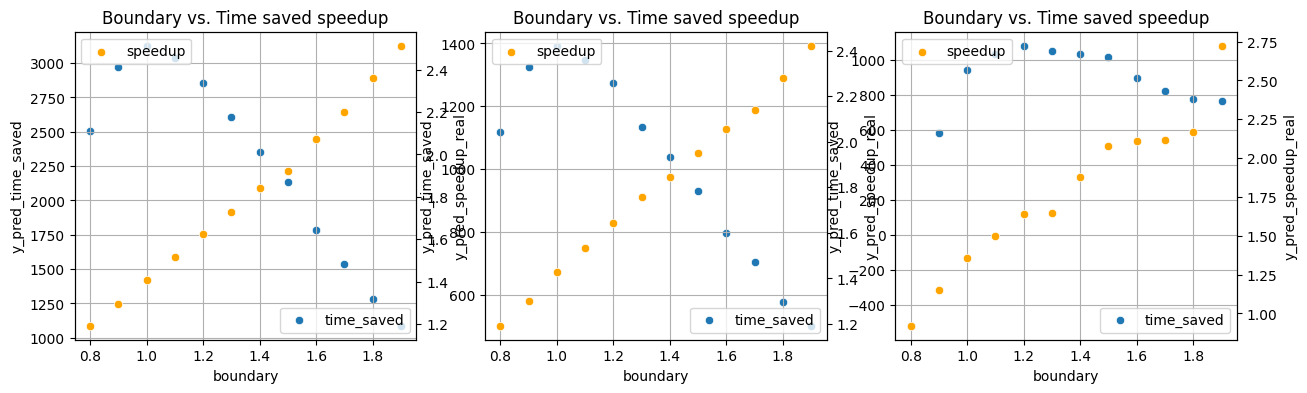

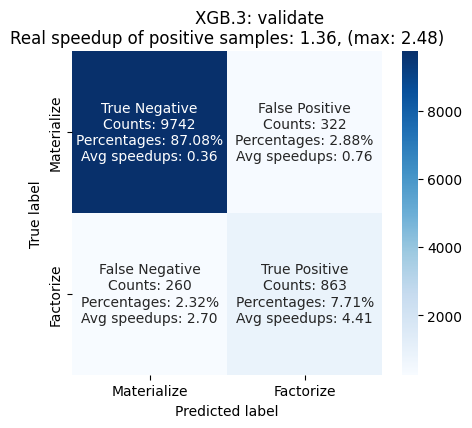

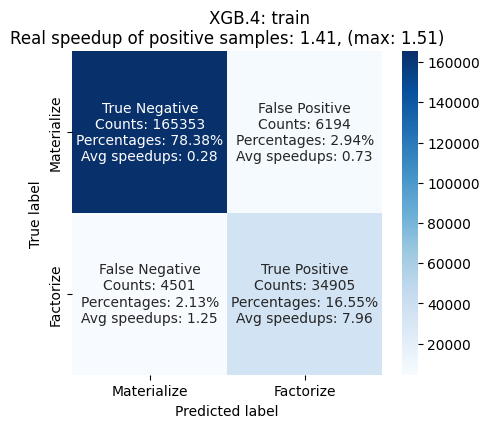

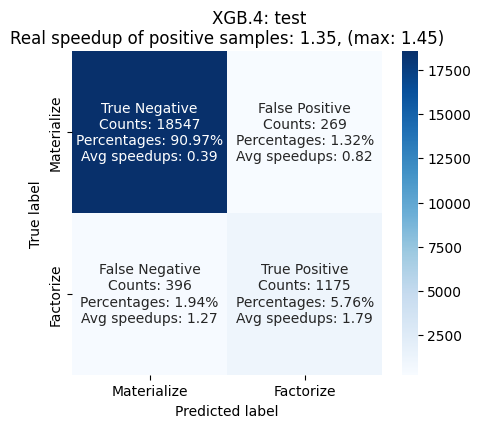

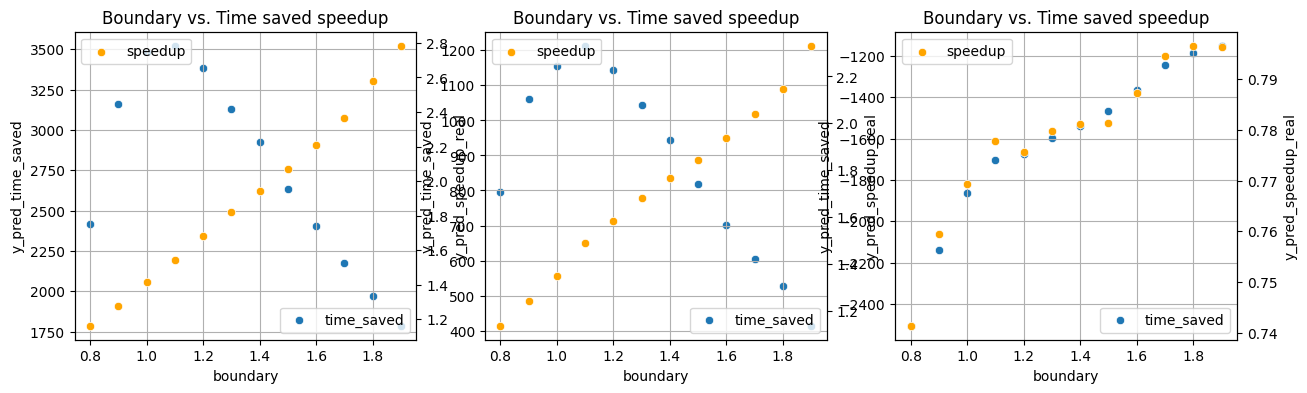

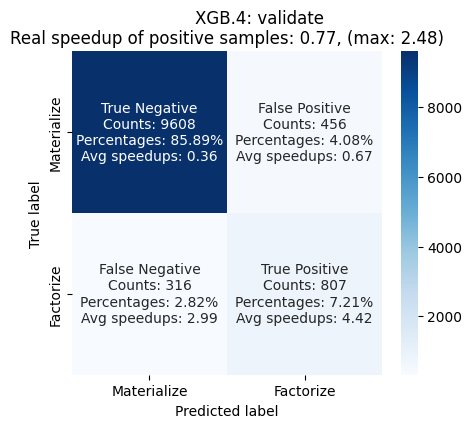

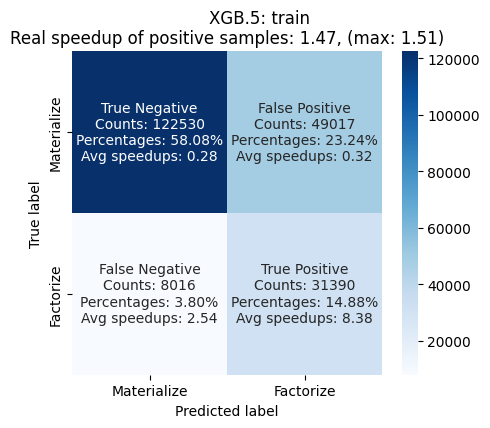

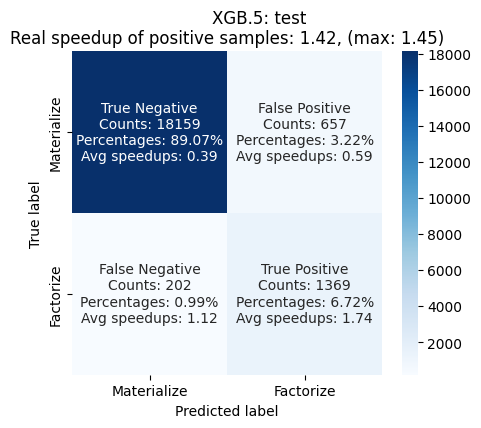

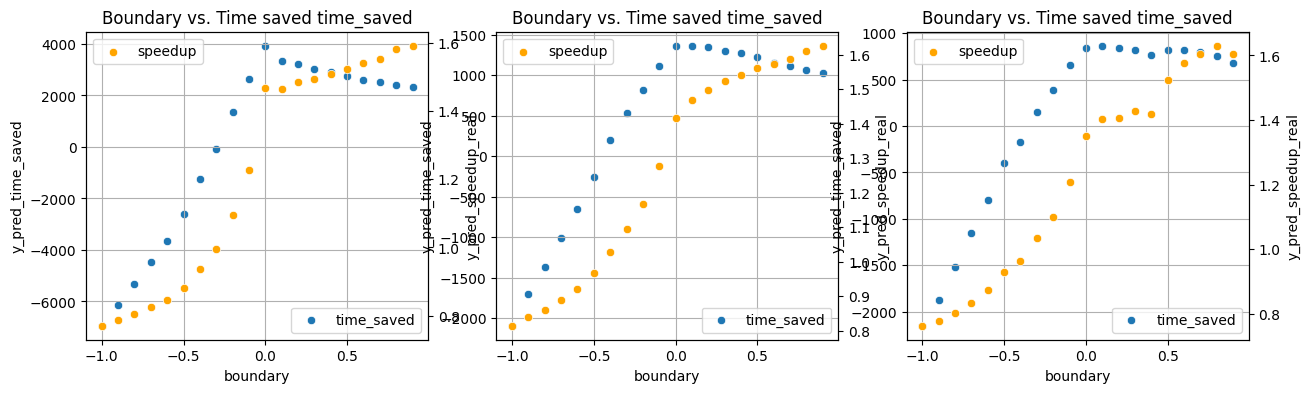

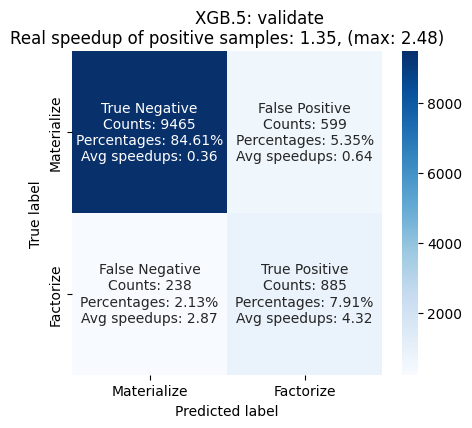

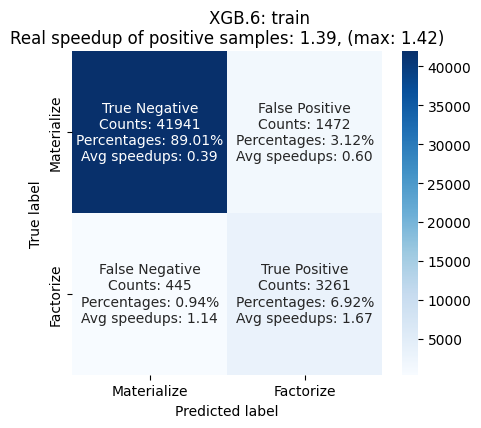

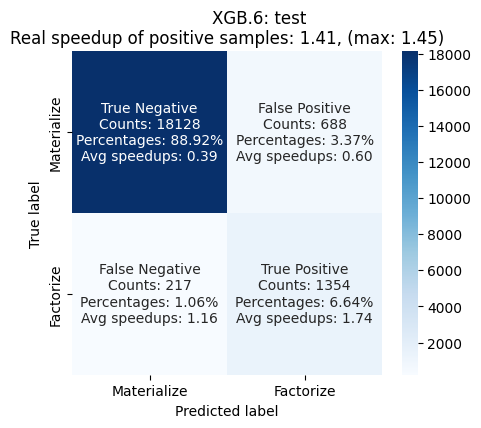

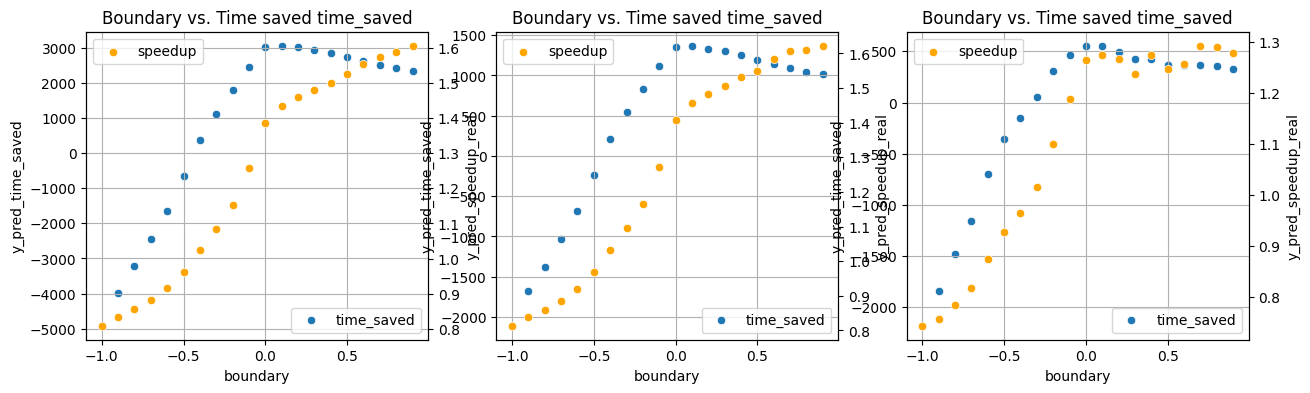

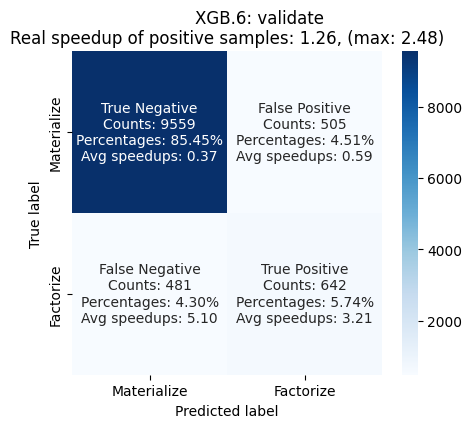

In [8]:
l= list(zip(["speedup", "time_saved", ["times_mean", "materialized_times_mean"]]*2, [True, False]*3))
l.sort(key=lambda x: str(x[0]))
display(l)
xgb_results = {}
xgb_estimators = {}
for i, (target_col, only_model) in enumerate(l):
    xgb_estimators[f"XGB.{i+1}"] = (target_col, only_model), train_and_eval(f"XGB.{i+1}",X_train, y_train, X_test, y_test, X_validate, y_validate, target_col, only_model=only_model)


In [9]:
import pickle
with open("trained_models/xgb3.pkl", "wb") as f:
    pickle.dump(xgb_estimators["XGB.3"][1], f)

In [10]:
xgb_results

{('XGB.1', 'train'): {'r2': 0.9877179171002828,
  'mean_squared_error': 0.14817492331383111,
  'accuracy': 0.9672106793437891,
  'precision': 0.7395256040789182,
  'recall': 0.9001618996222343,
  'f1': 0.8119751734209566,
  'speedup': {'y_true_mat_time': 10884.924061771591,
   'y_true_fact_time': 7684.917906483865,
   'y_true_best_time': 7684.917906483865,
   'y_true_time_saved': 3200.006155287726,
   'y_true_speedup_avg': 1.6098942396715852,
   'y_true_speedup_real': 1.4164008248660456,
   'y_pred_mat_time': 10968.717654134598,
   'y_pred_fact_time': 7903.654712044974,
   'y_pred_best_time': 7804.833423420539,
   'y_pred_time_saved': 3065.062942089624,
   'y_pred_speedup_avg': 1.396621362090605,
   'y_pred_speedup_real': 1.3878032446709172,
   'TP': (3336, 1.6666538680803482),
   'FP': (1175, 0.6299588599784494),
   'TN': (42238, 0.38955531351454026),
   'FN': (370, 1.0981371575860892)}},
 ('XGB.1', 'test'): {'r2': 0.9641155409215494,
  'mean_squared_error': 0.43217098141250454,
  'ac

In [11]:
resdf = pd.DataFrame(xgb_results.values())
resdf['Model'] = [x[0] for x in xgb_results.keys()]
resdf['dataset'] = [x[1] for x in xgb_results.keys()]
resdf['target'] = np.array([[str(x[0])] * 3 for x in l]).flatten()
resdf['target'] = resdf['target'].replace({"['times_mean', 'materialized_times_mean']": "time_saved"})
resdf['pruned'] = np.array([[x[1]] * 3 for x in l]).flatten()
resdf = resdf.merge(pd.json_normalize(resdf.speedup), left_index=True, right_index=True)
resdf['fraction_of_optimal_time_saved'] = resdf.y_pred_time_saved / resdf.y_true_time_saved
resdf

,r2,mean_squared_error,accuracy,precision,recall,f1,speedup,Model,dataset,target,...,y_pred_fact_time,y_pred_best_time,y_pred_time_saved,y_pred_speedup_avg,y_pred_speedup_real,TP,FP,TN,FN,fraction_of_optimal_time_saved
0,0.987718,0.148175,0.967211,0.739526,0.900162,0.811975,"{'y_true_mat_time': 10884.924061771591, 'y_tru...",XGB.1,train,time_saved,...,7903.654712,7804.833423,3065.062942,1.396621,1.387803,"(3336, 1.6666538680803482)","(1175, 0.6299588599784494)","(42238, 0.38955531351454026)","(370, 1.0981371575860892)",0.957830
1,0.964116,0.432171,0.961103,0.696465,0.877785,0.776683,"{'y_true_mat_time': 4719.159600592462, 'y_true...",XGB.1,test,time_saved,...,3400.737772,3333.737901,1337.543366,1.393041,1.393310,"(1379, 1.7261692350405389)","(601, 0.6286757510057328)","(18215, 0.3884413349327769)","(192, 1.1691690298382336)",0.917364
2,0.668722,6.664310,0.938142,0.678246,0.730187,0.703259,"{'y_true_mat_time': 2792.661280960886, 'y_true...",XGB.1,validate,time_saved,...,2074.165577,1836.606720,1080.041789,3.081557,1.520711,"(820, 4.236045314841185)","(389, 0.6479313422625086)","(9675, 0.36568377456289797)","(303, 3.423765426609331)",0.647721
3,0.986871,0.040622,0.743535,0.402992,0.774628,0.530169,"{'y_true_mat_time': 12576.204111394778, 'y_tru...",XGB.2,train,time_saved,...,8579.205377,8377.519628,3958.790991,3.628560,1.461440,"(30525, 8.526161300201158)","(45221, 0.32258982782228574)","(126326, 0.2826764150724737)","(8881, 2.597258902011503)",0.929246
4,0.962344,0.453508,0.958503,0.686375,0.849777,0.759386,"{'y_true_mat_time': 4719.159600592462, 'y_true...",XGB.2,test,time_saved,...,3345.798306,3280.121365,1332.008032,1.388908,1.398114,"(1335, 1.74132067154413)","(610, 0.6176452289443654)","(18206, 0.38869215931555057)","(236, 1.1873081878747065)",0.913568
5,0.633545,7.371970,0.893269,0.480376,0.773820,0.592769,"{'y_true_mat_time': 2792.661280960886, 'y_true...",XGB.2,validate,time_saved,...,2361.549569,2057.717846,987.296560,2.448086,1.418071,"(869, 4.467136239366991)","(940, 0.5815392675868177)","(9124, 0.3554788359825236)","(254, 2.4764436630806457)",0.592100
6,0.970887,0.005919,0.987203,0.920119,0.916892,0.918503,"{'y_true_mat_time': 10884.924061771591, 'y_tru...",XGB.3,train,speedup,...,7691.904241,7657.462296,3127.004543,1.599728,1.406532,"(3398, 1.6587524141186296)","(295, 0.9198409013197796)","(43118, 0.39247845277639254)","(308, 1.0708680163889315)",0.977187
7,0.889971,0.024034,0.983911,0.895608,0.895608,0.895608,"{'y_true_mat_time': 4719.159600592462, 'y_true...",XGB.3,test,speedup,...,3246.550739,3214.071319,1392.798551,1.635470,1.429009,"(1407, 1.7224390500824447)","(164, 0.8893432774195307)","(18652, 0.3917778653580406)","(164, 1.106073691364906)",0.955262
8,0.233383,2.538484,0.947975,0.728270,0.768477,0.747834,"{'y_true_mat_time': 2792.661280960886, 'y_true...",XGB.3,validate,speedup,...,2649.272656,2143.271284,944.081706,3.420406,1.356355,"(863, 4.412556150862531)","(322, 0.7613202638449557)","(9742, 0.36387709772922183)","(260, 2.7035466316847505)",0.566184
9,0.986353,3.595565,0.949302,0.849291,0.885779,0.867151,"{'y_true_mat_time': 12576.204111394778, 'y_tru...",XGB.4,train,speedup,...,8420.112655,7952.891443,3484.213439,6.867293,1.413797,"(34905, 7.955789479330336)","(6194, 0.7332993644547967)","(165353, 0.27671199888096304)","(4501, 1.2509438394532648)",0.817848


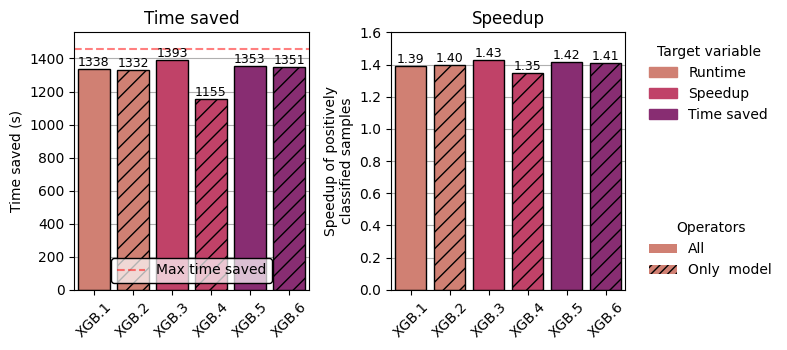

In [22]:
import matplotlib

pal = sns.color_palette("flare", 3)
colors = [pal[0], pal[0], pal[1], pal[1], pal[2], pal[2]]
colors = [sns.set_hls_values(c, s=0.5) for c in colors]
hatches = ["", "//", "", "//", "", "//"]	

f, axs = plt.subplots(1, 2, figsize=(8, 0.45*8))
labels = ["Time saved (s)", "Speedup of positively\nclassified samples", "Fraction of best time saved"]
titles = ["Time saved", "Speedup", "Performance"]
max_time_saved = resdf[resdf.dataset=='test'].y_true_time_saved.max()

for ax, var, label, title in zip(axs, ["y_pred_time_saved", "y_pred_speedup_real", "fraction_of_optimal_time_saved"][:2], labels[:2], titles[:2]):
    sns.barplot(
        data=resdf[(resdf.dataset == "test")],
        x="Model",
        y=var,
        ax=ax,
        saturation=0.6,
        edgecolor="black",
        linewidth=1,
        palette=sns.color_palette("flare"),
        # hue="target",
        # style='target'
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.grid(axis="y")
    ax.set_axisbelow(True)
    ax.set_ylabel(label)
    ax.set_xlabel("Target variable")
    ax.set_xlabel(None)
    ax.set_title(title)
    # ax.set_xticklabels(["XGB.1\nSpeedup", "XGB.2\nTime saved", "XGB.3 Time saved\n(separate F/M)"], rotation=45)
    fmt = ".2f"
    if var == "fraction_of_optimal_time_saved":
        # ax.set_ylim(0, 1)
        ...
    elif var == "y_pred_speedup_real":
        ax.set_ylim(top=1.6)
        ...
    elif var == "y_pred_time_saved":
        # ax.set_ylim(0, 1400)
        # ax.set_ylim(1000, max_time_saved+100)
        fmt = ".0f"
        ax.axhline(max_time_saved, color='red', linestyle='--', label="Max time saved", alpha=0.5)
        legend = ax.legend(loc='lower center', framealpha=0.8, fancybox=True)
        legend.get_frame().set_alpha(None)
        legend.get_frame().set_edgecolor('black')
        legend.get_frame().set_facecolor((1, 1, 1, 0.7))
        ax.set_ylim(top=max_time_saved+100)
        
    for i, bar in enumerate(ax.patches):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), format(bar.get_height(), fmt), 
                ha='center', va='bottom', fontsize=9)
        bar.set_facecolor(colors[i])
        bar.set_hatch(hatches[i])

cs = {'Runtime':colors[0], 'Speedup':colors[2], 'Time saved':colors[4]}         
labels = list(cs.keys())
handles = [plt.Rectangle((0,0),1,1, color=cs[label]) for label in labels]  
l1 = axs[1].legend(handles, labels, loc='upper left', title="Target variable", bbox_to_anchor=(1.05, 1), frameon=False)
hatches = {'All': None, 'Only  model': r'////'}
handles = [matplotlib.patches.Patch(facecolor=colors[0], hatch=hatches[label]) for label in hatches.keys()]
l2 = axs[1].legend(handles, hatches.keys(), loc='lower left', title="Operators" , bbox_to_anchor=(1.05, 0), frameon=False)
axs[1].add_artist(l1)
# axs[1].add_artist(l2)
f.tight_layout()
# f.savefig("/home/pepijn/Documents/uni/y5/thesis/writing/overleaf/chapters/05_cost_estimation/figures/xgb-models-compare.pdf", bbox_inches='tight')

In [21]:
y_true = y_validate.speedup
for m, target in zip(["XGB.3", "XGB.5"], ["speedup", "time_saved"]):
    y_pred = xgb_estimators[m][1].predict(X_validate)
    boundary = 1.0 if target == "speedup" else 0.0
    pd.DataFrame({f"xgb_y_true_{target}": y_true > boundary, f"xgb_y_pred_{target}": y_pred >boundary}).to_csv(
        f"evaluation/predictions/{m.replace('.','')}_label.csv"
    )

In [14]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer


# def time_saved(y_true, y_pred):
#     tot_time_pred = y_true[y_pred > 0].sum()
#     return tot_time_pred
       

# # Define the hyperparameter grid
# param_grid = {
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'subsample': [0.5, 0.7, 1], 
#     "lambda": [0.5, 1, 2],
#     "alpha": [0.5, 1, 2],
# }

# # Create the XGBoost model object
# xgb_model = xgboost.XGBRegressor(enable_categorical=True)

# # Create the GridSearchCV object
# grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring={"time_saved": make_scorer(time_saved, greater_is_better=True),
#                                                                  "mse": "neg_mean_squared_error"}, refit="time_saved", verbose=3)

# target_col = 'time_saved'
# loc = X_train["operator"].isin(model_operators)
# # Fit the GridSearchCV object to the training data
# grid_search.fit(X_train.loc[loc], y_train.loc[loc][target_col])

# # Print the best set of hyperparameters and the corresponding score
# print("Best set of hyperparameters: ", grid_search.best_params_)
# print("Best score: ", grid_search.best_score_)

In [15]:
# train_and_eval(X_train, y_train, X_test, y_test, X_validate, y_validate, 'time_saved', only_model=True, estimator_kwargs={'alpha': 0.5, 'lambda': 2, 'learning_rate': 0.1, 'max_depth': 7, 'subsample': 0.7})

In [16]:
# train_and_eval(X_train, y_train, X_test, y_test, X_validate, y_validate, ['materialized_times_mean', 'times_mean'], only_model=True, estimator_kwargs={'alpha': 2, 'lambda': 2, 'learning_rate': 0.1, 'max_depth': 7, 'subsample': 0.7})